In [199]:
import pandas as  pd
import numpy as np
import tensorflow as tf
from IPython.display import clear_output

In [4]:
df = pd.read_csv('data/car_acceptability/car_evaluation.csv', delimiter=",", names=["price", "maintenance", "num_door", "num_person", "lug_boot", "safety", "decision"])

In [48]:
df.head()

,price,maintenance,num_door,num_person,lug_boot,safety,decision
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


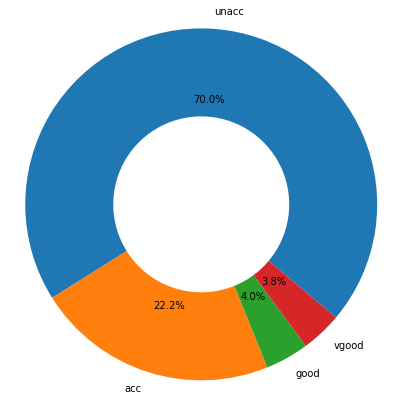

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
decision_des = df["decision"].value_counts()
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(decision_des.values, labels=decision_des.index, autopct='%1.1f%%', wedgeprops=dict(width=0.5), startangle=-40)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
# ax1.pie?

In [154]:
decision_des

unacc    1210
acc       384
good       69
vgood      65
Name: decision, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

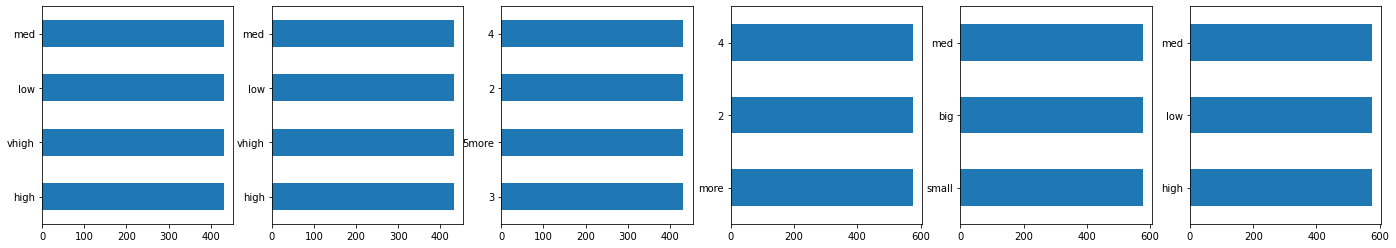

In [170]:
fig2, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(24, 4))
df.price.value_counts().plot(kind='barh', ax= ax1)
df.maintenance.value_counts().plot(kind='barh', ax= ax2)
df.num_door.value_counts().plot(kind='barh', ax= ax3)
df.num_person.value_counts().plot(kind='barh', ax= ax4)
df.lug_boot.value_counts().plot(kind='barh', ax= ax5)
df.safety.value_counts().plot(kind='barh', ax= ax6)

plt.show

In [115]:
df_price = pd.crosstab(df["decision"], df["price"])
df_door = pd.crosstab(df["decision"], df["num_door"])
df_maintenance = pd.crosstab(df["decision"], df["maintenance"])
df_num_person = pd.crosstab(df["decision"], df["num_person"])
df_lug_boot = pd.crosstab(df["decision"], df["lug_boot"])
df_safety = pd.crosstab(df["decision"], df["safety"])
df_price

price,high,low,med,vhigh
decision,,,,
acc,108,89,115,72
good,0,46,23,0
unacc,324,258,268,360
vgood,0,39,26,0


<function matplotlib.pyplot.show(close=None, block=None)>

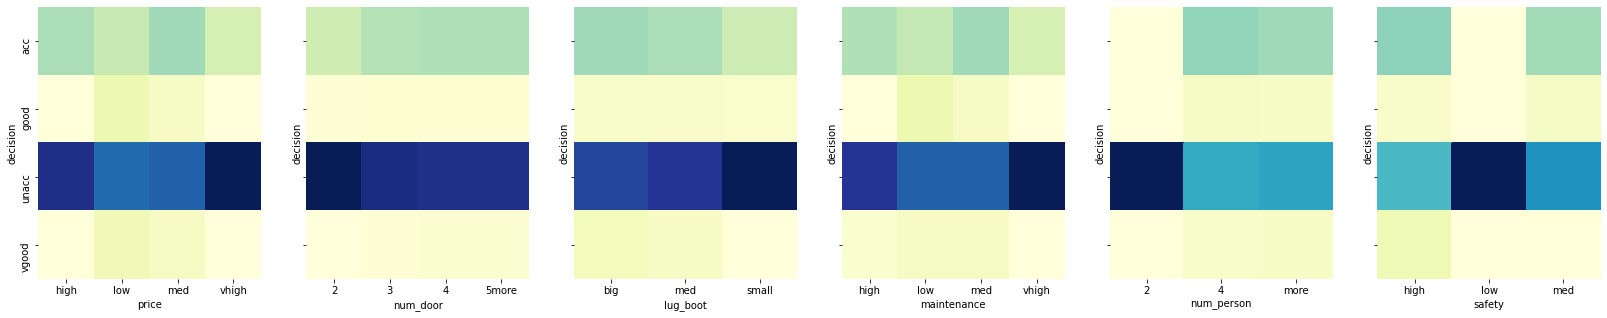

In [122]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(28, 5), sharey='all')
sns.heatmap(ax=ax1, data= df_price, cmap="YlGnBu", cbar=False)
sns.heatmap(ax=ax2, data= df_door, cmap="YlGnBu", cbar=False)
sns.heatmap(ax=ax3, data= df_lug_boot, cmap="YlGnBu", cbar=False)
sns.heatmap(ax=ax4, data= df_maintenance, cmap="YlGnBu", cbar=False)
sns.heatmap(ax=ax5, data= df_num_person, cmap="YlGnBu", cbar=False)
sns.heatmap(ax=ax6, data= df_safety, cmap="YlGnBu", cbar=False)
plt.show

In [195]:
df_tf = df.copy()
test = df_tf.sample(200)
train = df_tf[~df_tf.index.isin(test.index.tolist())]
train_label = train.pop('decision')
test_label = test.pop('decision')
train_label = np.where(train_label=='unacc', 0, 1)
test_label = np.where(test_label=='unacc', 0, 1)

def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
df_tf.pop('decision')
feature_columns = []
for feature_name in df_tf.columns.tolist():
    vocabulary = df_tf[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

In [196]:
example = dict(train.head(1))
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 1., 0., 0.]], dtype=float32)

In [197]:
NUM_EXAMPLES = len(label)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(train, train_label)
eval_input_fn = make_input_fn(test, test_label, shuffle=False, n_epochs=1)

In [200]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.940000
accuracy_baseline         0.705000
auc                       0.992908
auc_precision_recall      0.982409
average_loss              0.256991
label/mean                0.295000
loss                      0.256991
precision                 0.960784
prediction/mean           0.300763
recall                    0.830508
global_step             100.000000
dtype: float64


In [201]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.990000
accuracy_baseline         0.705000
auc                       0.999760
auc_precision_recall      0.999440
average_loss              0.043809
label/mean                0.295000
loss                      0.043809
precision                 0.967213
prediction/mean           0.292980
recall                    1.000000
global_step             100.000000
dtype: float64


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\ASUS\AppData\Local\Temp\tmp0cizkcbq\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


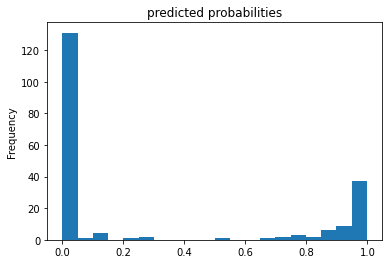

In [202]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

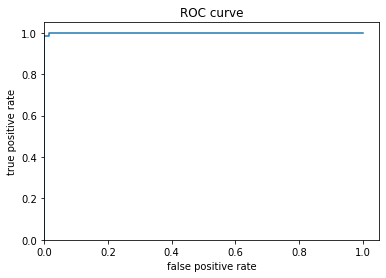

In [204]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_label, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

### Case 2    

In [216]:
df_tf2 = df.copy()
classes_2 = df_tf2["decision"].unique().tolist()
test2 = df_tf2.sample(200)
train2 = df_tf2[~df_tf2.index.isin(test2.index.tolist())]
train_label2 = train2.pop('decision')
train_label2 = train_label2.map(classes_2.index)
test_label2 = test2.pop('decision')
test_label2 = test_label2.map(classes_2.index)

def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
df_tf2.pop('decision')
feature_columns_2 = []
for feature_name in df_tf2.columns.tolist():
    vocabulary = df_tf2[feature_name].unique()
    feature_columns_2.append(one_hot_cat_column(feature_name, vocabulary))

In [217]:
# Training and evaluation input functions.
train_input_fn_2 = make_input_fn(train2, train_label2)
eval_input_fn_2 = make_input_fn(test2, test_label2, shuffle=False, n_epochs=1)

In [219]:
linear_est_2 = tf.estimator.LinearClassifier(feature_columns_2, n_classes=len(classes_2))

# Train model.
linear_est_2.train(train_input_fn_2, max_steps=100)

# Evaluation.
result2 = linear_est_2.evaluate(eval_input_fn_2)
clear_output()
print(pd.Series(result2))

accuracy          0.825000
average_loss      0.437568
loss              0.437568
global_step     100.000000
dtype: float64


In [222]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 1
est2 = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=n_batches,
                                           n_classes=len(classes_2))

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est2.train(train_input_fn_2, max_steps=100)

# Eval.
result2 = est2.evaluate(eval_input_fn_2)
clear_output()
print(pd.Series(result2))

accuracy          0.995000
average_loss      0.073219
loss              0.073219
global_step     100.000000
dtype: float64


In [266]:
def input_fn(features, batch_size=256):
    """An input function for prediction."""
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

preds = est2.predict(eval_input_fn_2)
for i in preds:
    print(i)
    break

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\ASUS\AppData\Local\Temp\tmpwiq141rf\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'logits': array([ 1.3447002,  4.4075346, -2.9973981, -1.6854258], dtype=float32), 'probabilities': array([4.4544607e-02, 9.5272410e-01, 5.7948957e-04, 2.1519298e-03],
      dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3]), 'all_classes': array([b'0', b'1', b'2', b'3'], dtype=object)}
